# Neural Networks for Data Science Applications
## Second Homework: Experimenting with modularity in deep learning

**Name**: *Mario Napoli*

**Matricola**: *2015169*

> ✍ Upload the completed notebook **at least two days prior** to the exam's date on Google Classroom. For example, for the January call (25/01/2023), the final deadline is **23/01/2023 at 23:59** (GMT+1).

**Overview**: The homework is composed of three parts: (i) selecting a dataset and training a standard neural network (<ins>4 points</ins>); (ii) implementing a modular architecture (either an early-exit model or a mixture-of-experts model) and testing it (<ins>6 points</ins>); (iii) implementing a load balancing regularization (ONLY if you did not upload the 1st homework or if you want to improve your mark, </ins>5 points</ins>).

**IMPORTANT - read carefully before starting**:

> 🟨 *External material*: if you use any external material or inspiration for the code, reference it *explicitly* in the corresponding cell. For the textual descriptions, copy-paste *is not allowed*. <ins>Not following these two points is an immediate 0 mark</ins>.

> 🔵 *Grammar*: for the textual descriptions, I will remove points for too many grammatical or textual errors. Please try to be precise and provide nice-to-read descriptions, like if you were writing a report.

> 🟥 *Vectorization and TensorFlow*: like for the first homework, this must be done fully in TensorFlow and vectorizing the code as much as possible (e.g., do not loop explicitly over the batch dimension).

> 🟪 *Math*: you can also use LaTeX in Markdown if you need to write equations or if you need generic math notation.

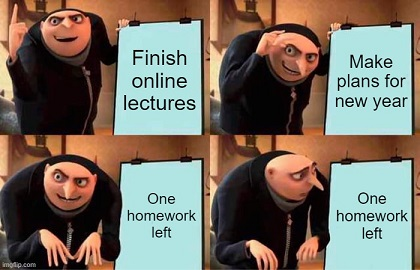

In [ ]:
import tensorflow as tf

In [ ]:
## Install Tensorflow Addons
!pip install tensorflow_addons

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 612.1/612.1 kB 10.6 MB/s eta 0:00:00


In [ ]:
## Import utils
import os
import glob
import matplotlib.pyplot as plt
import timeit
from tqdm import *

from tensorflow import keras

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import tensorflow_addons as tfa
import shutil
from pathlib import Path
import warnings

from keras.layers import Conv2D, BatchNormalization, ReLU, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential, load_model
from keras.utils import image_dataset_from_directory
from keras.metrics import Precision, Recall, CategoricalAccuracy, Mean
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow_addons.metrics import F1Score

from keras.losses import CategoricalCrossentropy
from tensorflow.math import reduce_max
from keras.optimizers import Adam

warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


### Warm-up: Selecting a dataset

During the course, we were able to see only a small selection of datasets. For this homework, you are free to select any dataset that you believe interesting (images, audios, texts, graphs)...

A few repositories that you can look at:

1. The catalog of [TensorFlow Datasets](https://www.tensorflow.org/datasets/).
2. The [Kaggle catalog](https://www.kaggle.com/data). For downloading data from Kaggle on Google Colab, you will need to [load your Kaggle authentication token](https://colab.research.google.com/github/corrieann/kaggle/blob/master/kaggle_api_in_colab.ipynb).
3. The [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets.php).
4. The [🤗 HuggingFace Datasets](https://huggingface.co/docs/datasets/) repository.

You are not bound to these; any open repository is okay. As a rule of thumb, the choice of dataset will not influence the mark (with few exceptions, see below), so you can select a complexity that you believe adequate to your skills.

🟩 **Please do:**

1. Provide a complete description of the dataset and the task below.
2. You are not limited to classification tasks. However, tasks that were not seen during the course (e.g., segmentation) **must be thoroughly explained in the text**.
3. Data preprocessing should be done as much as possible in `tf.data`.

🟥 **Please don't:**

1. Absolutely do not use datasets that were seen during our lab sessions.
2. Do not use MNIST, CIFAR-10, CIFAR-100, or any simple variation (e.g., Fashion MNIST).

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of the dataset below (e.g., source, task, bibliographic reference if necessary...), both as text and in the comments of the code.*

**TODO**: add description here (1-2 paragraphs).

### **Task description**
**Scene Classification** is a task in which scenes from photographs are categorically classified. Unlike object classification, which focuses on classifying prominent objects in the foreground, Scene Classification uses the layout of objects within the scene, in addition to the ambient context, for classification[[**Scene classification with Convolutional Neural Networks**](http://cs231n.stanford.edu/reports/2017/pdfs/102.pdf)].

### **Dataset**

The dataset used is [**intel-image-classification**](https://www.kaggle.com/datasets/puneet6060/intel-image-classification), it's composed by 6 classes representing different environments:

0 - buildings;

1 - forest;

2 - glacier;

3 - mountain;

4 - sea;

5 - street.


The first part of this work concerns the import of data from kaggle and some **exploratory analysis** and **data-wrangling** operations

In [ ]:
# TODO: Insert any data loading code here. If the data loading part is complex,
# consider using a separate .py file that you can attach to the submission.

## Install kaggle
!pip install kaggle

In [ ]:
## Create an API Token from our kaggle account
## Upload kaggle.json to your Colab runtime

from google.colab import files
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name = fn, length = len(uploaded[fn])))

## Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 71 bytes


In [ ]:
!kaggle datasets download "puneet6060/intel-image-classification"

!unzip intel-image-classification.zip

In [ ]:
## Save the data paths

path_train = "/content/seg_train/seg_train"
path_test = "/content/seg_test/seg_test"
labels    = ["buildings","forest","glacier","mountain","sea","street"]

In [ ]:
## Check the number of images for each class
for label in labels:
    dir = os.path.join(path_train, label)
    print("Number of " + label + " images" ":\t", len(os.listdir(dir)))

Number of buildings images:	 2191
Number of forest images:	 2271
Number of glacier images:	 2404
Number of mountain images:	 2512
Number of sea images:	 2274
Number of street images:	 2382


While there is minimal difference between the number of images in each class, we can assume the dataset is balanced.

With the following function it is possible to randomly display images within the dataset.

In [ ]:
## This function is used to visualize random for each class
import random
def image_plot(path, labels, num_images):
    """Input:
       Output: """

    ## Set Figsize
    plt.figure(figsize = (15, 10))

    for label in range(len(labels)):
        ## Save the path for each class
        dir = os.path.join(path, labels[label])
        size = len(os.listdir(dir))
        idx = idx = random.sample(range(0, int(size)), k=num_images)
        c = 0
        for i in idx:
            img_path = os.path.join(dir, os.listdir(dir)[i])
            img = plt.imread(img_path)

            plt.subplot(len(labels), num_images, label*num_images + c + 1)
            plt.imshow(img)

            ## Set the name of classes along y axis
            if c == 0:
                plt.ylabel(labels[label], fontsize = 20)
            c = c+1

    plt.setp(plt.gcf().get_axes(), xticks = [], yticks = []);
    plt.tight_layout()

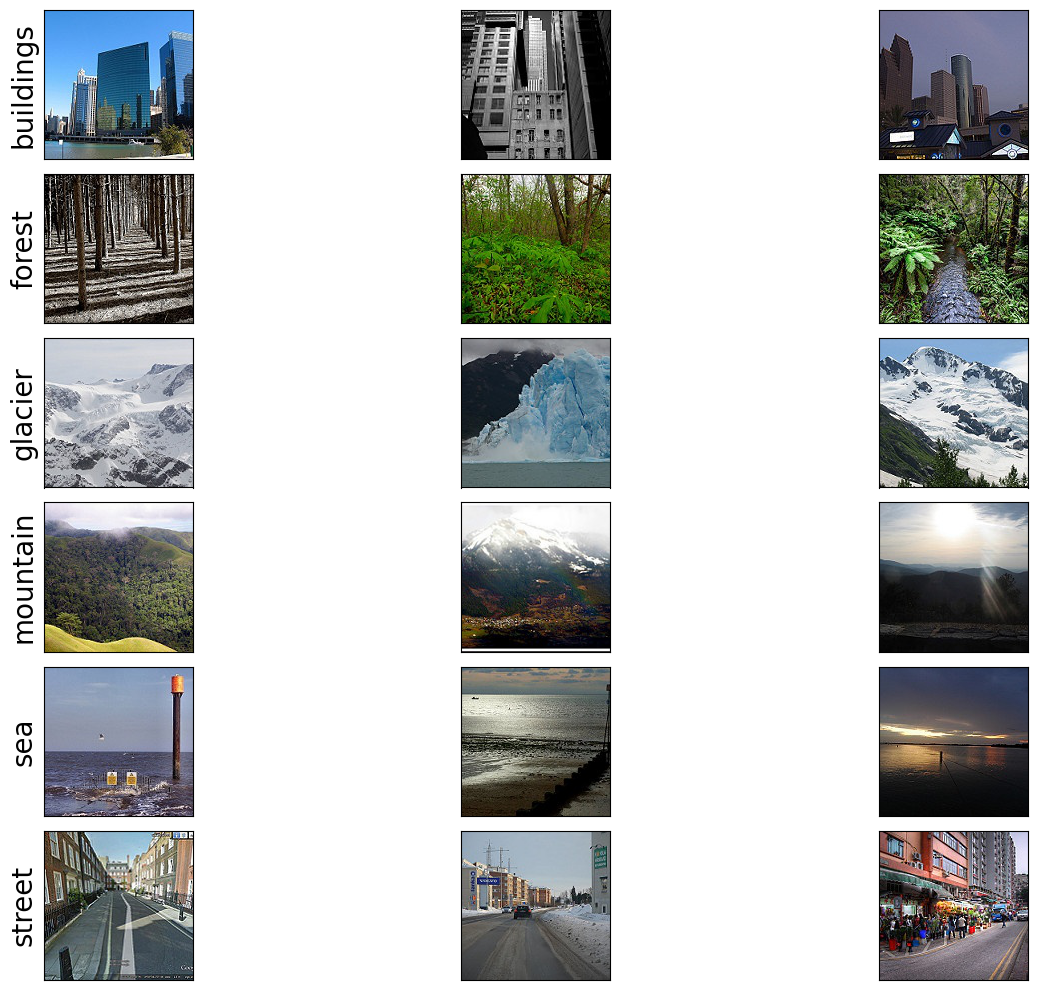

In [ ]:
## Plot random images
image_plot(path_train, labels, 3)

For each class, 5 images are shown.

At this point, the data present in the directory is loaded and the training, validation and test set are obtained.

In [ ]:
## Import Datasets



## Set the batch size and img dimention
batch_size = 32
img_dim  = 150

print("-----------------")
print("Training Set:")
print("-----------------")

X_train = image_dataset_from_directory(
    path_train,
    image_size = (img_dim, img_dim),
    subset = "training",
    validation_split = 0.3,
    seed = 123,
    label_mode = "categorical"
)

print("-----------------")
print("Validation Set")
print("-----------------")


## Validation Data
X_val = image_dataset_from_directory(
    path_train,
    image_size = (img_dim, img_dim),
    subset = "validation",
    validation_split = 0.3,
    seed = 123       ,
    label_mode = "categorical"

)

print("-----------------")
print("Test Set")
print("-----------------")

X_test = image_dataset_from_directory(
    path_test,                            ## Path test
    image_size = (img_dim, img_dim), ## Image Size
    validation_split = 0,                 ## Testing
    seed = 123,                           ## Set seed
    label_mode = "categorical"
)


n_classes = 6

-----------------
Training Set:
-----------------
Found 14034 files belonging to 6 classes.
Using 9824 files for training.
-----------------
Validation Set
-----------------
Found 14034 files belonging to 6 classes.
Using 4210 files for validation.
-----------------
Test Set
-----------------
Found 3000 files belonging to 6 classes.


The images in the directory used for model training have been split into the training (70%) and validation set (30%).

**Data Agumentation**

In the following steps, data augmentation is performed, in order to increase the number of the training data, and avoid possible overfitting situation.

In [ ]:
## Function to apply data augmentation to a single batch
def augment_data(batch_x, batch_y):
    ## Apply data augmentation transformations
    augmented_batch_x = tf.image.random_flip_left_right(batch_x)
    augmented_batch_x = tf.image.random_flip_up_down(batch_x)
    augmented_batch_x = tf.image.random_brightness(augmented_batch_x, max_delta=0.2)
    augmented_batch_x = tf.image.random_contrast(augmented_batch_x, lower=0.5, upper=1.5)

    return augmented_batch_x, batch_y

augmented_train_data = X_train.map(augment_data)

In [ ]:
X_train_aug = X_train.concatenate(augmented_train_data)

### Exercise 1: Train on your data (4 points)

This part is straightforward: create a model, according to everything we saw in the course, and train it on the data you have loaded. You are free to use any components that were not included in the course (layers, losses, metrics, ...), provided you give a brief description below.

🟧 You will have to modify this model for Exercise 2, so consider carefully your choice here.

✍ **DESCRIPTION OF THE CODE**

*Provide a small description of (i) the model, (ii) the task, (iii) any notable features of your training process.*

**TODO**: add description here (1-2 paragraphs).

The following architecture consists of three layers composed by:

- 2D Convolution;
- BatchNormalizzation;
- ReLU Activation Function;
- Max Pooling;
- Dropout.

The **L2 regularization** was also used in the model. This technique used to control the complexity of a model and reduce overfitting by adding a penalty term to the loss function that encourages smaller weights.
L2 regularization can sometimes improve the numerical stability of the model's optimization process.

After these three layers, we also have an additional final layer.
In the last layer we find a Dense layer with 256 neurons, followed by dropouts, and finally we have the output neurons.

In [ ]:
# TODO: add the model definition and model training code here (as many cells as you need).

from tensorflow.keras import regularizers

model = Sequential([
    ## Layer 1
    Conv2D(32, (7, 7), input_shape=(150, 150, 3), padding='same', kernel_regularizer=regularizers.l2(0.05)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),

    ## Layer 2
    Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.05)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),

    ## Layer 3
    Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.05)),
    BatchNormalization(),
    ReLU(),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
    Dropout(0.5),
    Dense(n_classes, activation='softmax')
])

Before compiling the model, some parameters useful for training have been set.

In [ ]:
# You can train using fit() or a custom training loop, equivalently.
## Training set up

## Choose the number of epochs
num_epochs = 50

In [ ]:
## Metrics

metrics = ["accuracy",
           Precision(name = "Precision"),
           Recall(name = "Recall"),
           F1Score(num_classes = 6, threshold = 0.5)]

## Compile the model
model.compile(loss = "categorical_crossentropy",
              optimizer = "adam",
              metrics = metrics)






**Model Checkpoint** and **Early Stopping** are also used.

**Model checkpoint** save the model with the best validation loss.

Instead **Early Stopping** is a form of regularization that stops the training process of a neural network before it reaches the maximum number of epochs or iterations [[**Early Stopping in Neural Networks: Pros and Cons**](https://www.linkedin.com/advice/1/what-benefits-drawbacks-early-stopping#:~:text=Early%20stopping%20is%20a%20form,to%20increase%20or%20stops%20improving.)]



In [ ]:
## Best model
checkpoint  = ModelCheckpoint("model.h5", monitor = "val_loss", save_best_only = True, mode = "min", verbose = 1)

## the early stopping
early_stop  = EarlyStopping(monitor = "val_loss", mode = "min", patience = 10)
reduce_lr   = ReduceLROnPlateau(monitor = "val_loss", factor = tf.math.sqrt(0.1), patience = 5, min_delta = 0.05,verbose = 1)

In [ ]:
## Train the model
start = timeit.default_timer()

model_history = model.fit(X_train_aug, epochs = num_epochs, verbose = 1,
                          batch_size = batch_size, callbacks = [checkpoint, early_stop, reduce_lr], validation_data = X_val)

stop = timeit.default_timer()
print("Computational Time:", stop - start)

Epoch 1/50
613/614 [============================>.] - ETA: 0s - loss: 7.1591 - accuracy: 0.4756 - Precision: 0.5881 - Recall: 0.3115 - f1_score: 0.3871
Epoch 1: val_loss improved from inf to 3.78368, saving model to model.h5
614/614 [==============================] - 33s 48ms/step - loss: 7.1519 - accuracy: 0.4755 - Precision: 0.5880 - Recall: 0.3114 - f1_score: 0.3870 - val_loss: 3.7837 - val_accuracy: 0.3705 - val_Precision: 0.4221 - val_Recall: 0.1995 - val_f1_score: 0.1462 - lr: 0.0010
Epoch 2/50
613/614 [============================>.] - ETA: 0s - loss: 1.9475 - accuracy: 0.5369 - Precision: 0.6878 - Recall: 0.3468 - f1_score: 0.4387
Epoch 2: val_loss improved from 3.78368 to 2.02039, saving model to model.h5
614/614 [==============================] - 33s 53ms/step - loss: 1.9473 - accuracy: 0.5370 - Precision: 0.6877 - Recall: 0.3468 - f1_score: 0.4387 - val_loss: 2.0204 - val_accuracy: 0.5128 - val_Precision: 0.6293 - val_Recall: 0.3238 - val_f1_score: 0.3509 - lr: 0.0010
Epoch 

✍ **RESULTS**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly. Explain them in code or in text, equivalently.*

Several measures have been considered. In particular, the trend of the accuracy and of the Loss obtained on the training set and on the validation set are shown below.

- $Accuracy = \frac{TP + TN}{TP + TN + FP + FN}$


In [ ]:
# TODO: add metrics and/or graphs showing the model was trained correctly.

## Training Metrics
train_loss = model_history.history["loss"]
train_accuracy = model_history.history["accuracy"]
val_loss = model_history.history["val_loss"]
val_accuracy = model_history.history["val_accuracy"]

learning_rate = model_history.history['lr']
learning_rate = model_history.history['lr']

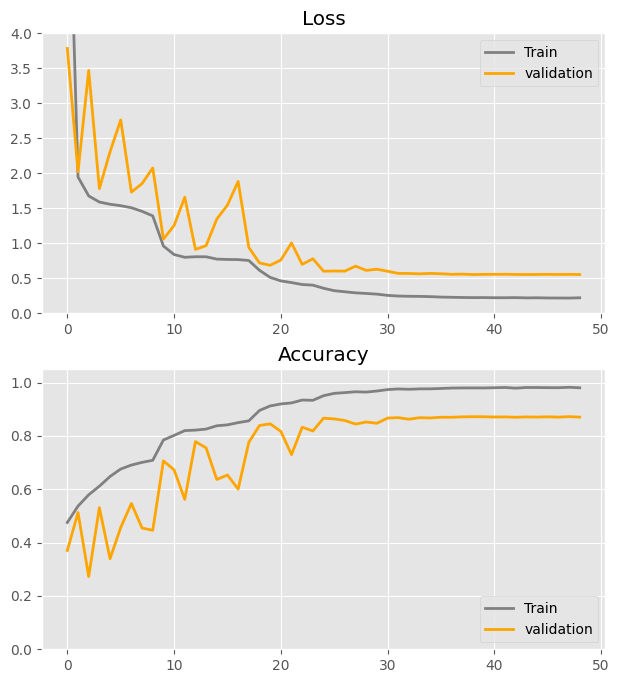

In [ ]:
plt.style.use("ggplot")
plt.figure(figsize = (16, 8))
#plt.subplots(nrows=3, ncols=1, figsize=(12, 10))

## Loss Plot
plt.subplot(221)
## Train
plt.plot(train_loss, color = "grey", label = "Train", linewidth = 2)
## Validation
plt.plot(val_loss, color = "orange", label = "validation", linewidth = 2)
plt.ylim(0, 4)
plt.title("Loss")
plt.xlabel("")
plt.legend()

## Accuracy Plot
plt.subplot(223)
## Train
plt.plot(train_accuracy, color = "grey", label = "Train", linewidth = 2)
## Validation
plt.plot(val_accuracy, color = "orange", label = "validation", linewidth = 2)
plt.ylim(0, 1.05)
plt.title("Accuracy")
plt.xlabel("")
plt.legend(loc = "lower right")

plt.show()

Training loss shows reduced variability and converges to zero more rapidly. However, the validation loss also exhibits a declining trend. The model's performance could probably improve if we trained it for more epochs.

Additionally, the metrics exhibit reduced variability after the initial 30 training epochs. This suggests that performance tends to stabilize around specific values, indicating consistency.



## **Prediction Step**

Best model used to make the forecasts.

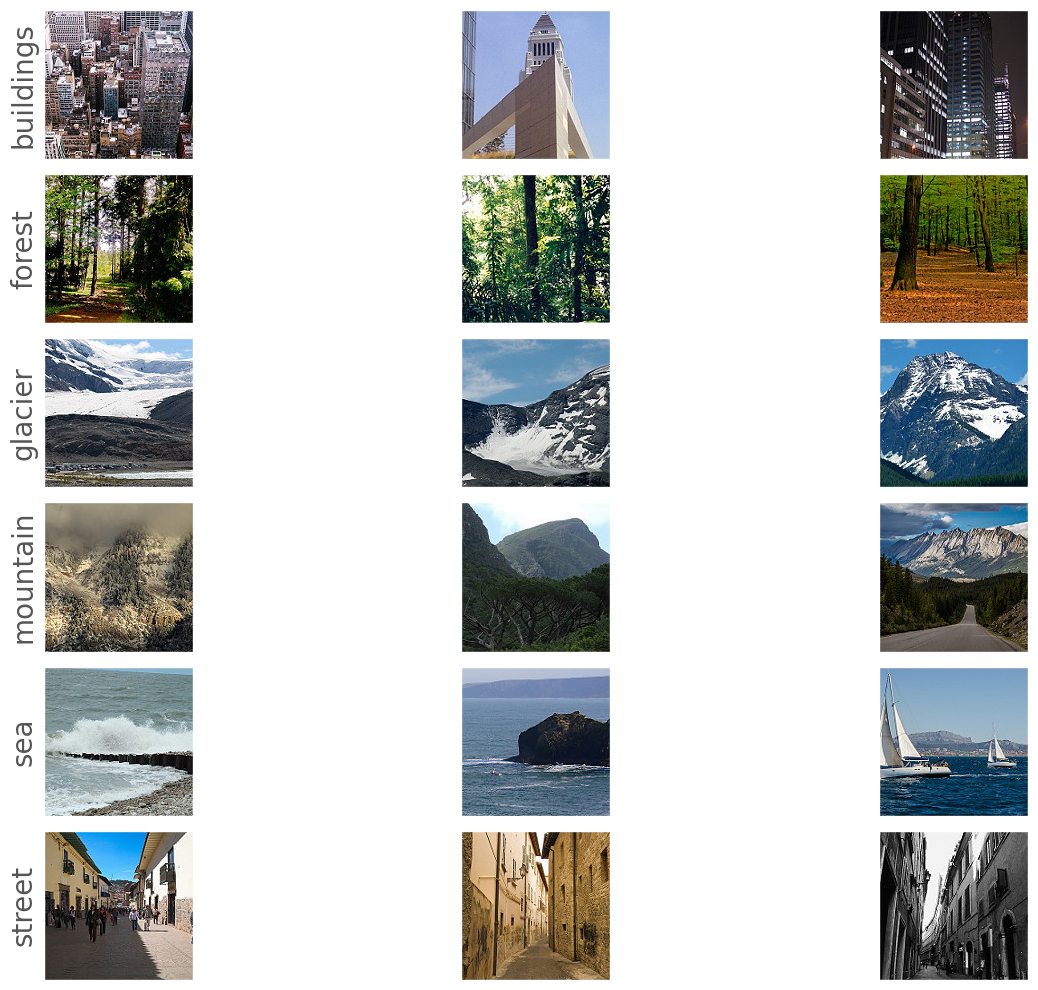

In [ ]:
## Show random test images

image_plot(path_train, labels, 3)

In [ ]:
## Check the number of images for each class into the test set
for label in labels:
    dir = os.path.join(path_test, label)
    print("Number of " + label + " images" ":\t", len(os.listdir(dir)))

Number of buildings images:	 437
Number of forest images:	 474
Number of glacier images:	 553
Number of mountain images:	 525
Number of sea images:	 510
Number of street images:	 501


In [ ]:
## Load model
best_model = load_model("model.h5")

In [ ]:
## Evaluate on Test Set
best_model.evaluate(X_test)

94/94 [==============================] - 4s 39ms/step - loss: 0.5552 - accuracy: 0.8667 - Precision: 0.8746 - Recall: 0.8603 - f1_score: 0.8682


[0.5551798939704895,
 0.8666666746139526,
 0.8746187686920166,
 0.8603333234786987,
 array([0.8444976 , 0.9668049 , 0.8065764 , 0.8284133 , 0.8917073 ,
        0.87103176], dtype=float32)]

In [ ]:
## Prediction
y_soft = best_model.predict(X_test)
y_pred = tf.argmax(y_soft, axis = 1)


res = []
## Save Y test
for step, (X_batch_test, Y_batch_test) in enumerate(X_test):
  res.append(tf.argmax(Y_batch_test, axis = 1))
  #print(tf.argmax(Y_batch_test, axis = 1))


y_test = tf.concat((res),axis = 0)

94/94 [==============================] - 2s 19ms/step


---------------
Classes names
['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
---------------


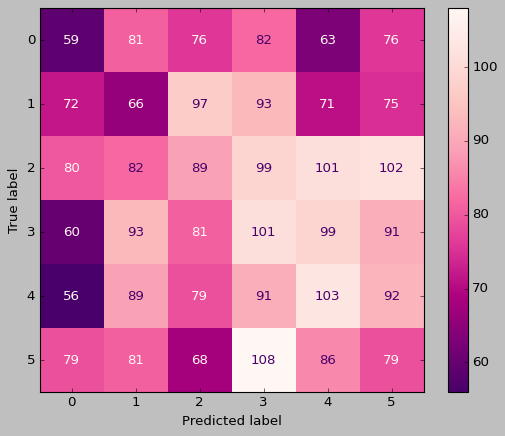

In [ ]:
## Confusion Matrix
plt.style.use("classic")

print("---------------")
print("Classes names")
print(X_test.class_names)
print("---------------")



## Confusion Matrix Plot
cm_cnn      = confusion_matrix(y_test, y_pred)
cm_cnn_plot = ConfusionMatrixDisplay(cm_cnn)
cm_cnn_plot.plot(values_format = "g", cmap = "RdPu_r")

From the confusion matrix it emerges that there is a lot of confusion between the classes.

A possible future upgrade for this work could be to use some techniques to better understand the reason for so much confusion. Some possible methods are:
1. View the results of intermediate convolutions;
2. Use Grad-CAM heat-maps to identify erroneous areas of emphasis by our models.

One of the factors that probably negatively affects our results is [Inter-class similarity](https://arxiv.org/pdf/2109.11891.pdf#:~:text=Inter%2Dclass%20similarity%20occurs%20when,class%20have%20drastically%20different%20appearances.), which occurs when objects belonging to different classes have visually similar appearance due to minute variations in the morphological features.

Possible strategies to deal with this problem could be:

1. Increase diversity of training data;

2. Use an appropriate loss function: Choose or design a loss function that penalizes similarity between classes;

3. Use more complex models;

4. Use ensemble strategies;

5. Add more regularization;

6. Increase data augmentation.

Some of these strategies can also be useful for managing overfitting.


### Exercise 2 (6 points): Adding modularity to the network

The purpose of this second exercise is to implement a "modular" network, in the sense we discussed in class. In particular, two variants are allowed for this exercise (<ins>only one variant should be implemented</ins>):

1.   **Variant 2a, Early-exits**: Modify the model in Exercise 1 by adding 2 or more early exits and train it.
2.   **Variant 2b, Mixture-of-experts**: Modify the model in Exercise 1 by replacing at least one layer of the model with a MoE layer.

🟩 You are free to design the model as much as you want: you can follow the slides directly (e.g., summing the losses of all early exits during training), or you can follow some of the bibliographic references in the slides, or even any other paper you find online (e.g., the MoE model may route single tokens, entire images, with different routing mechanisms, etc.).

🟥 **Please don't:**

1. Copy-paste from the web (immediate zero mark).

✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the model (what you implemented, bibliographic references, how you are training it, notable implementation issues, etc.).*

**TODO**: add a complete description here (2-3 paragraphs).

#### **Modula Neural Netwok (Early Exits variant)**

Early exits allow to obtain predictions at intermediate points of the stack . These multi-output networks have a number of advantages, including:
1. significant reductions of the inference time;
2. reduced tendency to overfitting and vanishing gradients;
3. capability of being distributed over multi-tier computation platforms.

**References**

[**Why should we add early exits to neural networks?**](https://arxiv.org/pdf/2004.12814.pdf)


The constructor of the "EarlyExit" class takes as arguments:
1. the threshold value ("threshold"): represents the confidence threshold above which a preliminary prediction is accepted as the final output;
2. a list of exit indexes ("exits"): a list of indices specifying the exit points in the model, i.e. the points where the preliminary predictions are made.

The first part of the model is represented by the backbone model, defined in the previous points of this work.

Furthermore, the class defines, also, a list of self.classifiers, one for each exit point specified in the "exits" list. Each classifier consists of a flatten followed by a dense layer with softmax activation.

The "call" method takes as arguments:
1. "inputs" (the input data);
2. "training" (a boolean flag indicating whether the model is running in training mode);
3. "labels" (the input data labels).
The method iterates through the layers of the model, performing data forwarding. When it reaches an exit point specified in the "exits" list, it calculates the output of the corresponding classifier. If the model is run in inference mode (Training == False), it is checked if the output exceeds the specified confidence threshold. If so, the output is returned as the final output of the model. Finally, the method returns a list containing the intermediate outputs of the classifiers, as well as the output of the last layer of the model when it reaches index 18.



In [ ]:
# TODO: add all code here, using as many cells as you need. Train the new model.

## This class represents a convolutional neural network model with the ability to perform "early exits",
## i.e. to provide a preliminary prediction before completing the entire model run.

## Define the Erly exit class

class EarlyExits(tf.keras.Model):
    def __init__(self, threshold, exits, num_classes = 6):

## The constructor of the "EarlyExit" class takes as arguments:
## 1. the threshold value ("threshold"): represents the confidence threshold above which a preliminary prediction is accepted as the final output;
## 2. a list of exit indexes ("exits"): a list of indices specifying the exit points in the model, i.e. the points where the preliminary predictions are made.

## The first part of the model is represented by the backbone model, defined in the previous points of this work.

## Furthermore, the class defines, also, a list of self.classifiers, one for each exit point specified in the "exits" list.
## Each classifier consists of a flatten followed by a dense layer with softmax activation.

        super(EarlyExits, self).__init__()
        self.threshold = threshold
        self.exits = exits
        #self.loss_fn = CategoricalCrossentropy()
        self.model_layers = Sequential([
            ## Layer 1
            Conv2D(32, (7, 7), input_shape=(150, 150, 3), padding='same', kernel_regularizer=regularizers.l2(0.05)),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D((2, 2)),

            ## Layer 2
            Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.05)),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D((2, 2)),

            ## Layer 3
            Conv2D(64, (5, 5), padding='same', kernel_regularizer=regularizers.l2(0.05)),
            BatchNormalization(),
            ReLU(),
            MaxPooling2D((2, 2)),


            Flatten(),
            Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
            Dropout(0.5),
            Dense(6, activation='softmax')
        ])


        self.classifiers = [Sequential([
            Flatten(),
            Dense(num_classes, activation = "softmax")
        ]) for _ in exits]


    def call(self, inputs, training = None, labels = None):

## The "call" method takes as arguments:
## 1. "inputs": the input data;
## 2. "training": boolean, indicating whether the model is running in training mode;
## 3. "labels": the input data labels.
## The method iterates through the layers of the model, performing data forwarding.
## When it reaches an exit point specified in the "exits" list, it calculates the output of the corresponding classifier.
## If the model is run in inference mode (Training == False), it is checked if the output exceeds the specified confidence threshold.
## If so, the output is returned as the final output of the model. Finally, the method returns a list containing the intermediate outputs of the classifiers,
## as well as the output of the last layer of the model when it reaches index 18.

      x = inputs
      res = []
      c = 0
      for i, layer in enumerate(self.model_layers.layers):
        x = layer(x)
        if i in self.exits:
          output = self.classifiers[c](x)
          res.append(output)

          if training == False:
            if reduce_max(output, axis = 1) > self.threshold:
              return output
          c = c+1

        if i == 15:
          res.append(x)

      return res

In [ ]:
ee_mod = EarlyExits(exits = [4,8,12], threshold = 0.5)

In [ ]:
@tf.function
def train_step(inputs, targets, model, optimizer, loss_fn, loss_metric, final_acc, ee1_acc, ee2_acc, ee3_acc):
    with tf.GradientTape() as tape:

        outputs = model(inputs, training=True) ## Prediction

        loss = loss_fn(targets, outputs) ## Loss Function

    ## Gradients
    grads = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    final_loss = loss_metric(loss) ## Cross-Entropy Loss

    ## Accuracies
    final_acc.update_state(targets, outputs[-1])
    ee1_acc.update_state(targets, outputs[0])
    ee2_acc.update_state(targets, outputs[1])
    ee3_acc.update_state(targets, outputs[2])

In [ ]:
start = timeit.default_timer()

In [ ]:
# Initialize metrics and lists

## If in the first point the training stopped due to the "erly stopping",
## it is advisable to choose the number of epochs in which the training was interrupted
epochs = 50

optimizer = Adam()
cce = CategoricalCrossentropy()

loss_metric = Mean()
Accuracy = CategoricalAccuracy()

ee1_acc = CategoricalAccuracy()
ee2_acc = CategoricalAccuracy()
ee3_acc = CategoricalAccuracy()


losses = []
Accuracies = []
ee1_accs = []
ee2_accs = []
ee3_accs = []



In [ ]:
## Loss function = sum of the partial ones
def Summed_Loss(y_true, y_pred):
  loss_1 = cce(y_true, y_pred[0])
  loss_2 = cce(y_true, y_pred[1])
  loss_3 = cce(y_true, y_pred[2])
  model_loss = cce(y_true, y_pred[-1])
  final_loss = loss_1 + loss_2 + loss_3 + model_loss
  return final_loss

In [ ]:
# Define the custom training loop

# Start the custom training loop
for epoch in tqdm(range(epochs)):
    print("\nStart of epoch %d" % (epoch))

    for step, (inputs, targets) in enumerate(X_train_aug):
        train_step(inputs, targets, ee_mod, optimizer, Summed_Loss, loss_metric, Accuracy, ee1_acc, ee2_acc, ee3_acc)


    print("Loss:", float(loss_metric.result()))
    losses.append(loss_metric.result())

    ## Print the final accuracies
    print("Accuracy over epoch: %.4f" % (float(Accuracy.result()),))
    print("Early Exit 1 over epoch acc: %.4f" % (float(ee1_acc.result()),))
    print("Early Exit 2 over epoch acc: %.4f" % (float(ee2_acc.result()),))
    print("Early Exit 3 over epoch acc: %.4f" % (float(ee3_acc.result()),))

    Accuracies.append(Accuracy.result())
    ee1_accs.append(ee1_acc.result())
    ee2_accs.append(ee2_acc.result())
    ee3_accs.append(ee3_acc.result())

    ## Reset metrics for the next epoch
    loss_metric.reset_states()
    Accuracy.reset_states()
    ee1_acc.reset_states()
    ee2_acc.reset_states()
    ee3_acc.reset_states()

stop = timeit.default_timer()
print("Computational Time:", stop - start)

  0%|          | 0/50 [00:00<?, ?it/s]


Start of epoch 0


  2%|▏         | 1/50 [00:40<33:27, 40.96s/it]

Loss: 39.89335632324219
Accuracy over epoch: 0.4849
Early Exit 1 over epoch acc: 0.4792
Early Exit 2 over epoch acc: 0.4894
Early Exit 3 over epoch acc: 0.5127

Start of epoch 1


  4%|▍         | 2/50 [01:05<24:52, 31.10s/it]

Loss: 27.309690475463867
Accuracy over epoch: 0.5742
Early Exit 1 over epoch acc: 0.5899
Early Exit 2 over epoch acc: 0.5742
Early Exit 3 over epoch acc: 0.5939

Start of epoch 2


  6%|▌         | 3/50 [01:35<23:56, 30.57s/it]

Loss: 15.143609046936035
Accuracy over epoch: 0.6368
Early Exit 1 over epoch acc: 0.6760
Early Exit 2 over epoch acc: 0.6560
Early Exit 3 over epoch acc: 0.6580

Start of epoch 3


  8%|▊         | 4/50 [01:59<21:41, 28.29s/it]

Loss: 9.392293930053711
Accuracy over epoch: 0.6846
Early Exit 1 over epoch acc: 0.7515
Early Exit 2 over epoch acc: 0.7298
Early Exit 3 over epoch acc: 0.7218

Start of epoch 4


 10%|█         | 5/50 [02:24<20:12, 26.95s/it]

Loss: 5.766814708709717
Accuracy over epoch: 0.7186
Early Exit 1 over epoch acc: 0.8090
Early Exit 2 over epoch acc: 0.7917
Early Exit 3 over epoch acc: 0.7826

Start of epoch 5


 12%|█▏        | 6/50 [02:48<19:07, 26.07s/it]

Loss: 4.468425750732422
Accuracy over epoch: 0.7491
Early Exit 1 over epoch acc: 0.8343
Early Exit 2 over epoch acc: 0.8316
Early Exit 3 over epoch acc: 0.8174

Start of epoch 6


 14%|█▍        | 7/50 [03:13<18:18, 25.54s/it]

Loss: 3.5134873390197754
Accuracy over epoch: 0.7722
Early Exit 1 over epoch acc: 0.8569
Early Exit 2 over epoch acc: 0.8458
Early Exit 3 over epoch acc: 0.8394

Start of epoch 7


 16%|█▌        | 8/50 [03:37<17:39, 25.23s/it]

Loss: 2.751594066619873
Accuracy over epoch: 0.7987
Early Exit 1 over epoch acc: 0.8786
Early Exit 2 over epoch acc: 0.8617
Early Exit 3 over epoch acc: 0.8566

Start of epoch 8


 18%|█▊        | 9/50 [04:02<17:04, 24.99s/it]

Loss: 2.2895712852478027
Accuracy over epoch: 0.8217
Early Exit 1 over epoch acc: 0.8905
Early Exit 2 over epoch acc: 0.8831
Early Exit 3 over epoch acc: 0.8736

Start of epoch 9


 20%|██        | 10/50 [04:43<19:56, 29.92s/it]

Loss: 2.0264365673065186
Accuracy over epoch: 0.8420
Early Exit 1 over epoch acc: 0.8985
Early Exit 2 over epoch acc: 0.8883
Early Exit 3 over epoch acc: 0.8866

Start of epoch 10


 22%|██▏       | 11/50 [05:07<18:22, 28.26s/it]

Loss: 1.81674325466156
Accuracy over epoch: 0.8583
Early Exit 1 over epoch acc: 0.9036
Early Exit 2 over epoch acc: 0.8982
Early Exit 3 over epoch acc: 0.8983

Start of epoch 11


 24%|██▍       | 12/50 [05:32<17:12, 27.17s/it]

Loss: 1.4633674621582031
Accuracy over epoch: 0.8775
Early Exit 1 over epoch acc: 0.9181
Early Exit 2 over epoch acc: 0.9073
Early Exit 3 over epoch acc: 0.9185

Start of epoch 12


 26%|██▌       | 13/50 [05:56<16:13, 26.31s/it]

Loss: 1.3392611742019653
Accuracy over epoch: 0.8894
Early Exit 1 over epoch acc: 0.9261
Early Exit 2 over epoch acc: 0.9041
Early Exit 3 over epoch acc: 0.9198

Start of epoch 13


 28%|██▊       | 14/50 [06:21<15:27, 25.77s/it]

Loss: 1.1299262046813965
Accuracy over epoch: 0.9020
Early Exit 1 over epoch acc: 0.9351
Early Exit 2 over epoch acc: 0.9157
Early Exit 3 over epoch acc: 0.9347

Start of epoch 14


 30%|███       | 15/50 [06:45<14:47, 25.36s/it]

Loss: 0.9852960705757141
Accuracy over epoch: 0.9149
Early Exit 1 over epoch acc: 0.9421
Early Exit 2 over epoch acc: 0.9249
Early Exit 3 over epoch acc: 0.9409

Start of epoch 15


 32%|███▏      | 16/50 [07:10<14:12, 25.08s/it]

Loss: 0.8833174109458923
Accuracy over epoch: 0.9242
Early Exit 1 over epoch acc: 0.9455
Early Exit 2 over epoch acc: 0.9271
Early Exit 3 over epoch acc: 0.9462

Start of epoch 16


 34%|███▍      | 17/50 [07:34<13:41, 24.90s/it]

Loss: 0.891282856464386
Accuracy over epoch: 0.9263
Early Exit 1 over epoch acc: 0.9403
Early Exit 2 over epoch acc: 0.9292
Early Exit 3 over epoch acc: 0.9468

Start of epoch 17


 36%|███▌      | 18/50 [08:15<15:51, 29.73s/it]

Loss: 0.7331678867340088
Accuracy over epoch: 0.9349
Early Exit 1 over epoch acc: 0.9539
Early Exit 2 over epoch acc: 0.9314
Early Exit 3 over epoch acc: 0.9547

Start of epoch 18


 38%|███▊      | 19/50 [08:40<14:32, 28.14s/it]

Loss: 0.7722419500350952
Accuracy over epoch: 0.9394
Early Exit 1 over epoch acc: 0.9443
Early Exit 2 over epoch acc: 0.9329
Early Exit 3 over epoch acc: 0.9553

Start of epoch 19


 40%|████      | 20/50 [09:04<13:31, 27.03s/it]

Loss: 0.6866378784179688
Accuracy over epoch: 0.9444
Early Exit 1 over epoch acc: 0.9520
Early Exit 2 over epoch acc: 0.9418
Early Exit 3 over epoch acc: 0.9569

Start of epoch 20


 42%|████▏     | 21/50 [09:28<12:41, 26.27s/it]

Loss: 0.6648356914520264
Accuracy over epoch: 0.9478
Early Exit 1 over epoch acc: 0.9494
Early Exit 2 over epoch acc: 0.9429
Early Exit 3 over epoch acc: 0.9641

Start of epoch 21


 44%|████▍     | 22/50 [09:53<11:59, 25.71s/it]

Loss: 0.6724640130996704
Accuracy over epoch: 0.9475
Early Exit 1 over epoch acc: 0.9521
Early Exit 2 over epoch acc: 0.9419
Early Exit 3 over epoch acc: 0.9647

Start of epoch 22


 46%|████▌     | 23/50 [10:17<11:23, 25.31s/it]

Loss: 0.6490083932876587
Accuracy over epoch: 0.9501
Early Exit 1 over epoch acc: 0.9496
Early Exit 2 over epoch acc: 0.9417
Early Exit 3 over epoch acc: 0.9667

Start of epoch 23


 48%|████▊     | 24/50 [10:42<10:52, 25.11s/it]

Loss: 0.6226846575737
Accuracy over epoch: 0.9526
Early Exit 1 over epoch acc: 0.9511
Early Exit 2 over epoch acc: 0.9493
Early Exit 3 over epoch acc: 0.9682

Start of epoch 24


 50%|█████     | 25/50 [11:06<10:23, 24.93s/it]

Loss: 0.6030349731445312
Accuracy over epoch: 0.9558
Early Exit 1 over epoch acc: 0.9541
Early Exit 2 over epoch acc: 0.9498
Early Exit 3 over epoch acc: 0.9708

Start of epoch 25


 52%|█████▏    | 26/50 [11:31<09:54, 24.77s/it]

Loss: 0.6005381941795349
Accuracy over epoch: 0.9561
Early Exit 1 over epoch acc: 0.9530
Early Exit 2 over epoch acc: 0.9509
Early Exit 3 over epoch acc: 0.9698

Start of epoch 26


 54%|█████▍    | 27/50 [11:55<09:27, 24.68s/it]

Loss: 0.5618086457252502
Accuracy over epoch: 0.9639
Early Exit 1 over epoch acc: 0.9552
Early Exit 2 over epoch acc: 0.9559
Early Exit 3 over epoch acc: 0.9740

Start of epoch 27


 56%|█████▌    | 28/50 [12:20<09:02, 24.68s/it]

Loss: 0.5173645615577698
Accuracy over epoch: 0.9632
Early Exit 1 over epoch acc: 0.9633
Early Exit 2 over epoch acc: 0.9574
Early Exit 3 over epoch acc: 0.9762

Start of epoch 28


 58%|█████▊    | 29/50 [13:01<10:20, 29.57s/it]

Loss: 0.610709547996521
Accuracy over epoch: 0.9605
Early Exit 1 over epoch acc: 0.9562
Early Exit 2 over epoch acc: 0.9511
Early Exit 3 over epoch acc: 0.9718

Start of epoch 29


 60%|██████    | 30/50 [13:25<09:21, 28.05s/it]

Loss: 0.4462459683418274
Accuracy over epoch: 0.9671
Early Exit 1 over epoch acc: 0.9679
Early Exit 2 over epoch acc: 0.9601
Early Exit 3 over epoch acc: 0.9789

Start of epoch 30


 62%|██████▏   | 31/50 [13:50<08:32, 26.99s/it]

Loss: 0.5037366151809692
Accuracy over epoch: 0.9669
Early Exit 1 over epoch acc: 0.9617
Early Exit 2 over epoch acc: 0.9604
Early Exit 3 over epoch acc: 0.9763

Start of epoch 31


 64%|██████▍   | 32/50 [14:14<07:52, 26.24s/it]

Loss: 0.5314332842826843
Accuracy over epoch: 0.9646
Early Exit 1 over epoch acc: 0.9606
Early Exit 2 over epoch acc: 0.9591
Early Exit 3 over epoch acc: 0.9777

Start of epoch 32


 66%|██████▌   | 33/50 [14:39<07:17, 25.76s/it]

Loss: 0.5329286456108093
Accuracy over epoch: 0.9679
Early Exit 1 over epoch acc: 0.9626
Early Exit 2 over epoch acc: 0.9606
Early Exit 3 over epoch acc: 0.9786

Start of epoch 33


 68%|██████▊   | 34/50 [15:04<06:46, 25.40s/it]

Loss: 0.4672701358795166
Accuracy over epoch: 0.9701
Early Exit 1 over epoch acc: 0.9657
Early Exit 2 over epoch acc: 0.9638
Early Exit 3 over epoch acc: 0.9787

Start of epoch 34


 70%|███████   | 35/50 [15:28<06:17, 25.13s/it]

Loss: 0.5045128464698792
Accuracy over epoch: 0.9686
Early Exit 1 over epoch acc: 0.9655
Early Exit 2 over epoch acc: 0.9633
Early Exit 3 over epoch acc: 0.9770

Start of epoch 35


 72%|███████▏  | 36/50 [15:53<05:49, 24.93s/it]

Loss: 0.4881177246570587
Accuracy over epoch: 0.9702
Early Exit 1 over epoch acc: 0.9692
Early Exit 2 over epoch acc: 0.9642
Early Exit 3 over epoch acc: 0.9790

Start of epoch 36


 74%|███████▍  | 37/50 [16:17<05:22, 24.78s/it]

Loss: 0.4451827108860016
Accuracy over epoch: 0.9722
Early Exit 1 over epoch acc: 0.9723
Early Exit 2 over epoch acc: 0.9658
Early Exit 3 over epoch acc: 0.9826

Start of epoch 37


 76%|███████▌  | 38/50 [16:58<05:55, 29.64s/it]

Loss: 0.42740195989608765
Accuracy over epoch: 0.9728
Early Exit 1 over epoch acc: 0.9736
Early Exit 2 over epoch acc: 0.9686
Early Exit 3 over epoch acc: 0.9829

Start of epoch 38


 78%|███████▊  | 39/50 [17:22<05:08, 28.05s/it]

Loss: 0.4745396375656128
Accuracy over epoch: 0.9720
Early Exit 1 over epoch acc: 0.9700
Early Exit 2 over epoch acc: 0.9652
Early Exit 3 over epoch acc: 0.9805

Start of epoch 39


 80%|████████  | 40/50 [17:47<04:29, 26.98s/it]

Loss: 0.5637590885162354
Accuracy over epoch: 0.9688
Early Exit 1 over epoch acc: 0.9672
Early Exit 2 over epoch acc: 0.9649
Early Exit 3 over epoch acc: 0.9822

Start of epoch 40


 82%|████████▏ | 41/50 [18:11<03:56, 26.23s/it]

Loss: 0.4199773073196411
Accuracy over epoch: 0.9732
Early Exit 1 over epoch acc: 0.9754
Early Exit 2 over epoch acc: 0.9713
Early Exit 3 over epoch acc: 0.9841

Start of epoch 41


 84%|████████▍ | 42/50 [18:36<03:25, 25.69s/it]

Loss: 0.3944564461708069
Accuracy over epoch: 0.9767
Early Exit 1 over epoch acc: 0.9770
Early Exit 2 over epoch acc: 0.9722
Early Exit 3 over epoch acc: 0.9853

Start of epoch 42


 86%|████████▌ | 43/50 [19:00<02:57, 25.29s/it]

Loss: 0.4948330819606781
Accuracy over epoch: 0.9729
Early Exit 1 over epoch acc: 0.9701
Early Exit 2 over epoch acc: 0.9675
Early Exit 3 over epoch acc: 0.9833

Start of epoch 43


 88%|████████▊ | 44/50 [19:25<02:30, 25.04s/it]

Loss: 0.42241302132606506
Accuracy over epoch: 0.9765
Early Exit 1 over epoch acc: 0.9764
Early Exit 2 over epoch acc: 0.9699
Early Exit 3 over epoch acc: 0.9860

Start of epoch 44


 90%|█████████ | 45/50 [19:49<02:04, 24.86s/it]

Loss: 0.4560106098651886
Accuracy over epoch: 0.9759
Early Exit 1 over epoch acc: 0.9753
Early Exit 2 over epoch acc: 0.9680
Early Exit 3 over epoch acc: 0.9834

Start of epoch 45


 92%|█████████▏| 46/50 [20:14<01:39, 24.77s/it]

Loss: 0.42706426978111267
Accuracy over epoch: 0.9754
Early Exit 1 over epoch acc: 0.9746
Early Exit 2 over epoch acc: 0.9712
Early Exit 3 over epoch acc: 0.9860

Start of epoch 46


 94%|█████████▍| 47/50 [20:38<01:14, 24.67s/it]

Loss: 0.4434657394886017
Accuracy over epoch: 0.9757
Early Exit 1 over epoch acc: 0.9757
Early Exit 2 over epoch acc: 0.9713
Early Exit 3 over epoch acc: 0.9852

Start of epoch 47


 96%|█████████▌| 48/50 [21:03<00:49, 24.70s/it]

Loss: 0.4806923270225525
Accuracy over epoch: 0.9798
Early Exit 1 over epoch acc: 0.9753
Early Exit 2 over epoch acc: 0.9705
Early Exit 3 over epoch acc: 0.9832

Start of epoch 48


 98%|█████████▊| 49/50 [21:44<00:29, 29.58s/it]

Loss: 0.3878249526023865
Accuracy over epoch: 0.9794
Early Exit 1 over epoch acc: 0.9787
Early Exit 2 over epoch acc: 0.9740
Early Exit 3 over epoch acc: 0.9857

Start of epoch 49


100%|██████████| 50/50 [22:08<00:00, 26.57s/it]

Loss: 0.46178409457206726
Accuracy over epoch: 0.9781
Early Exit 1 over epoch acc: 0.9754
Early Exit 2 over epoch acc: 0.9716
Early Exit 3 over epoch acc: 0.9839
Computational Time: 1331.7107886519998


In [ ]:
## Import test data with batch size 1
X_test_one_batch = image_dataset_from_directory(
    path_test,
    image_size = (img_dim, img_dim),
    validation_split = 0,
    seed = 123,
    label_mode = "categorical",
    batch_size = 1)

Found 3000 files belonging to 6 classes.


## Inference Step


In [ ]:
test_acc = tf.keras.metrics.CategoricalAccuracy()

for step, (inputs, targets) in enumerate(X_test_one_batch):
  output = ee_mod(inputs, training = False)
  test_acc.update_state(targets, output)

In [ ]:
print("Test Accuracy: %.4f" % (float(test_acc.result()),))
test_acc.reset_states()

Test Accuracy: 0.5413


✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the average accuracy of each early exit). Explain them in code or in text, equivalently.*

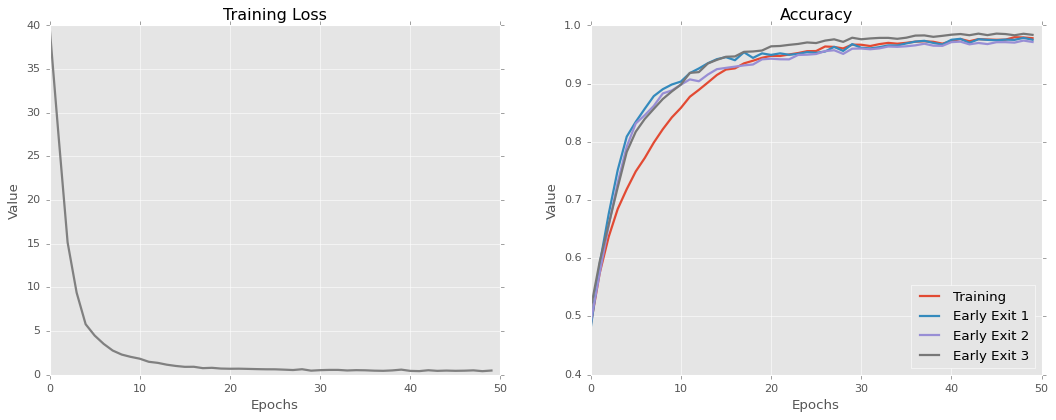

In [ ]:
# TODO: Add results here (anything appropriate is okay).

## Plot the average accuracy of each eatly exit
plt.style.use("ggplot")
plt.figure(figsize = (16, 12))

## Loss Plot
plt.subplot(221)
## Training Loss
plt.plot(losses, color = "grey", label = "Train", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Training Loss")

## Accuracy Plot
plt.subplot(222)
## Train
plt.plot(Accuracies,label = "Training", linewidth = 2)
plt.plot(ee1_accs, label = "Early Exit 1", linewidth = 2)
plt.plot(ee2_accs, label = "Early Exit 2", linewidth = 2)
plt.plot(ee3_accs, label = "Early Exit 3", linewidth = 2)
plt.xlabel("Epochs")
plt.ylabel("Value")
plt.title("Accuracy")
plt.legend(loc = "lower right")

plt.show()

Taking a look at the results obtained in the test phase and at the accuracy graph on the train, it emerges that we are in a situation of strong overfitting.

As mentioned before, there are several ways of handling this situation that could be considered for further work on this project. A solution that was not considered in the first point is that of introducing a Penalty for premature exits: In some cases, it is possible to apply a penalty during training for premature exits, i.e. when the model exit makes a prediction incorrect before reaching a threshold of confidence. This may encourage the model to try to improve the reliability of its predictions and to make better use of intermediate classification levels.

Speaking instead of the early exit technique, observing the different accuracies it can be noted that the values ​​of the accuracies obtained for the different exits are not very far from the accuracy value of the entire model. We can therefore conclude that if we are willing to give up some accuracy, exploiting the early exit principle, we could obtain performances similar to those we would obtain using the full-power model.

### Exercise 3 (5 points): Load balancing regularization

**This exercise is required only for students that have not submitted the first homework, or for students who want to raise their mid-term mark (mark <= 4.5/6). For a mark of 4.5/6 or higher, an additional point can also be recovered during the exam.**

**To recap**: if you submitted the mid-term homework, implement only Exercises 1 and 2, for a total of *10 points*. If you did not submit the mid-term homework, implement Exercises 1, 2, and 3 for a total of *15 points*.

For this exercise, you are asked to implement an additional **regularization term** as follows:

1.   If you followed variant 2a, add a regularization term that will balance the number of elements exiting at each early exit (e.g., a KL divergence w.r.t. an uniform distribution).
2.   If you followed variant 2b, add a regularization term that will balance the amount of tokens (or inputs) that each expert received (e.g., a KL divergence w.r.t. to an uniform distribution).

You have freedom here to follow the ideas from the slides or other ideas you may find in the literature.


✍ **DESCRIPTION OF THE CODE**

*Provide a complete description of the regularization term you implemented.*

**TODO**: add description (1-2 paragraphs).

In [ ]:
# TODO: add code here. Train again the model with the new regularization loss.

✍ **RESULTS AND EVALUATION**

*Provide below any metrics or plots that you think are interesting to show that the model was trained correctly (e.g., the load for each expert when training). Explain them in code or in text, equivalently.*

In [ ]:
# TODO: Add results here (anything appropriate is okay).

### Final checklist

1. Carefully check all textual descriptions and the code. Insert comments when needed. <ins>Check for TODO to see if you missed anything.</ins>
2. Run everything one final time. *Please do not send me notebooks with errors or cells that are not working.*
3. Send the completed notebook following the instructions on top.

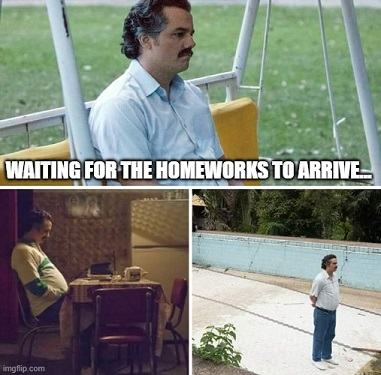